In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

d:\python\python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [79]:
features_num = [
    "Z_BEST", "z1_median", "Bw_f", "Bw_e", "Bw_e_raw", "R_f", "R_e", 
    "R_e_raw", "I_f", "I_e", "I_e_raw", "J_f", "J_e", "J_e_raw", "H_f", 
    "H_e", "H_e_raw", "Ks_f", "Ks_e", "Ks_e_raw", "ch1_f", "ch1_e", "ch1_e_raw", "ch2_f", 
    "ch2_e", "ch2_e_raw", "ch3_f", "ch3_e", "ch3_e_raw", "ch4_f", "ch4_e", "ch4_e_raw", "PACS_100_f", "PACS_100_e", "PACS_100_e_raw", "PACS_160_f", "PACS_160_e", 
    "PACS_160_e_raw", "SPIRE_250_f", "SPIRE_250_e", "SPIRE_250_e_raw", "SPIRE_350_f", "SPIRE_350_e", "SPIRE_350_e_raw", 
    "SPIRE_500_f", "SPIRE_500_e", "SPIRE_500_e_raw"

]
features_cat_binary = [
    "FLAG_OVERLAP", "XID+_rerun_mips", "XID+_rerun_pacs", "XID+_rerun_SPIRE", "CHANGE_FLAG_ID", 
    "CHANGE_FLAG_ZBEST", "CHANGE_FLAG_DEEP", "CHANGE_FLAG_FIR", "FLAG_GOOD"
]
features_cat_non_binary = [
    "FLAG_DEEP"
]
features_drop = [
    "Source_Name"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [80]:
# Creating the pipeline
transformer_num = make_pipeline(
    SimpleImputer(strategy="mean"),  # there are a few missing values
    StandardScaler(),
)
# Almost all cat features are already binary, so don't have to be one-hot encoded
transformer_cat_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
)
transformer_cat_non_binary = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse=False)
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat_binary, features_cat_binary),
    (transformer_cat_non_binary, features_cat_non_binary),
)

In [106]:
data = pd.read_csv("../../Data/Fangyou_data/Cleaned/Bootes_clean.csv")

In [107]:
data = data.dropna()

In [108]:
# Dropping rows with more than 6 Nan's
#data = data.dropna(axis=0, thresh=71)

In [109]:
# Dropping Columns with more than 100 NaN's
#data = data.dropna(axis=1, thresh=(len(data)-100))

In [110]:
# Dropping required columns
X = data.drop(columns=features_drop)
X = X.drop(columns=y_column)
y = data[y_column]

In [111]:
# Transforming y to labels
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [112]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [113]:
# Class weights
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# PCA

In [114]:
pca = PCA().fit(X_train)

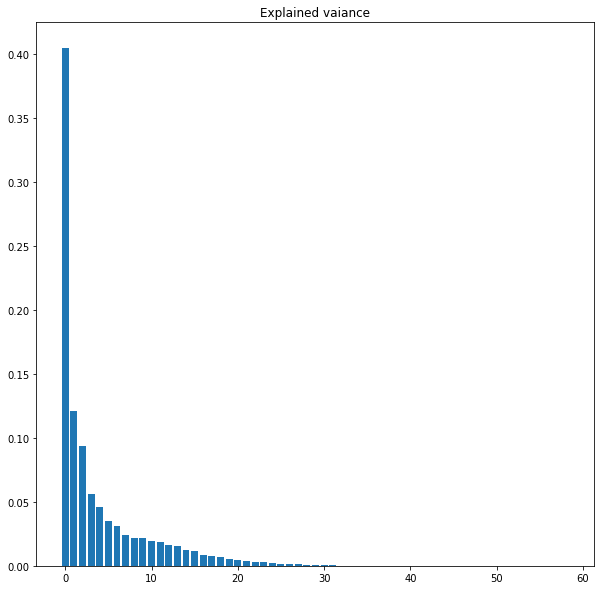

In [115]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance)
plt.title("Explained vaiance")
plt.show()

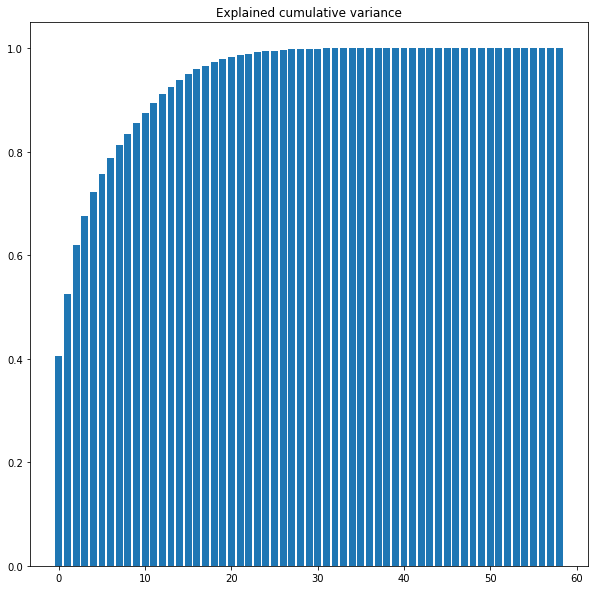

In [116]:
plt.figure(figsize=(10,10))
plt.bar(range(len(explained_variance)),explained_variance.cumsum())
plt.title("Explained cumulative variance")
plt.show()

# Random forest

In [117]:
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [118]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8203    0.3596    0.5000       292
quasar-like radio AGN / high-excitation radio galaxy     0.5000    0.0238    0.0455        42
                                     radio-quiet AGN     0.7857    0.4626    0.5824       214
                                 star-forming galaxy     0.8334    0.9862    0.9034      1593

                                            accuracy                         0.8295      2141
                                           macro avg     0.7349    0.4581    0.5078      2141
                                        weighted avg     0.8203    0.8295    0.7995      2141



[]

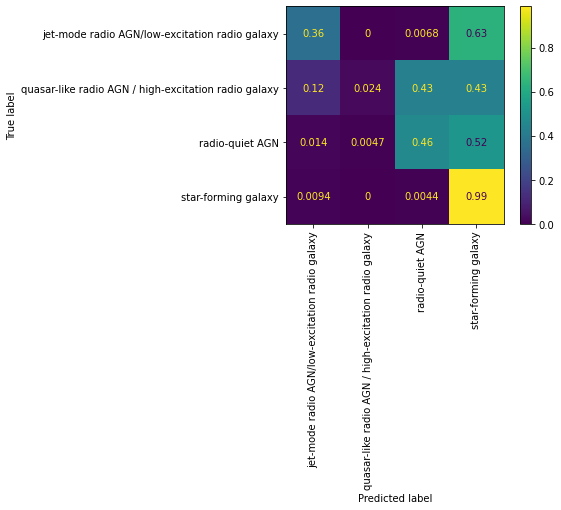

In [119]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [120]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

[]

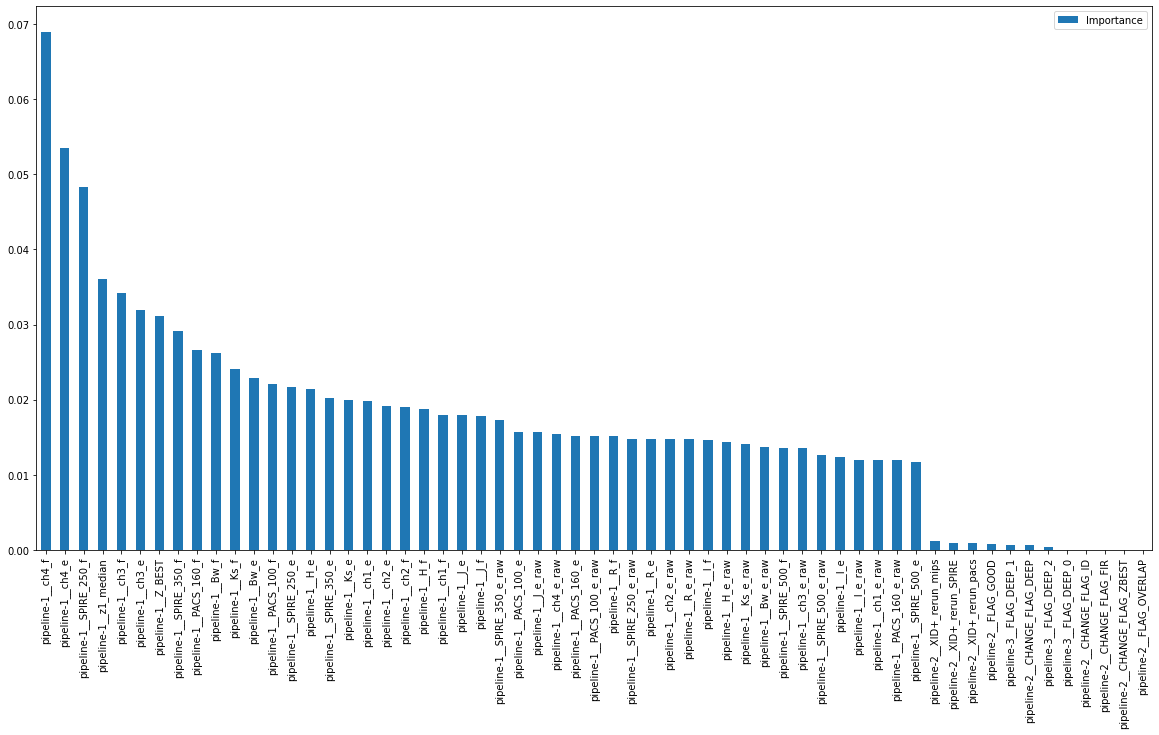

In [121]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)
plt.plot()

## Hyperparameter tuning

In [122]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [123]:
# Parameter space
parameters = {"n_estimators": [10,20,50,100,150,200],
             "criterion": ["gini", "entropy"],
             "max_depth": [10,30,50,70],
             "min_samples_split": [2,10,20],
             }

In [98]:
random_forest = RandomForestClassifier()
clf = GridSearchCV(estimator=random_forest, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=-1,
                  cv=2,
                  verbose=4)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits



KeyboardInterrupt



In [ ]:
clf

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

# XGboost

In [124]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

[22:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.04380
[1]	validation_0-mlogloss:0.85578
[2]	validation_0-mlogloss:0.73850
[3]	validation_0-mlogloss:0.65679
[4]	validation_0-mlogloss:0.59955
[5]	validation_0-mlogloss:0.56135
[6]	validation_0-mlogloss:0.53114
[7]	validation_0-mlogloss:0.51038
[8]	validation_0-mlogloss:0.49620
[9]	validation_0-mlogloss:0.48593
[10]	validation_0-mlogloss:0.47902
[11]	validation_0-mlogloss:0.47181
[12]	validation_0-mlogloss:0.46588
[13]	validation_0-mlogloss:0.46354
[14]	validation_0-mlogloss:0.46170
[15]	validation_0-mlogloss:0.46034
[16]	validation_0-mlogloss:0.46000
[17]	validation_0-mlogloss:0.45991
[18]	validation_0-mlogloss:0.45976
[19]	validation_0-mlogloss:0.46013

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [125]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7700    0.5274    0.6260       292
quasar-like radio AGN / high-excitation radio galaxy     0.4444    0.0952    0.1569        42
                                     radio-quiet AGN     0.7607    0.5794    0.6578       214
                                 star-forming galaxy     0.8717    0.9680    0.9173      1593

                                            accuracy                         0.8519      2141
                                           macro avg     0.7117    0.5425    0.5895      2141
                                        weighted avg     0.8383    0.8519    0.8367      2141



[]

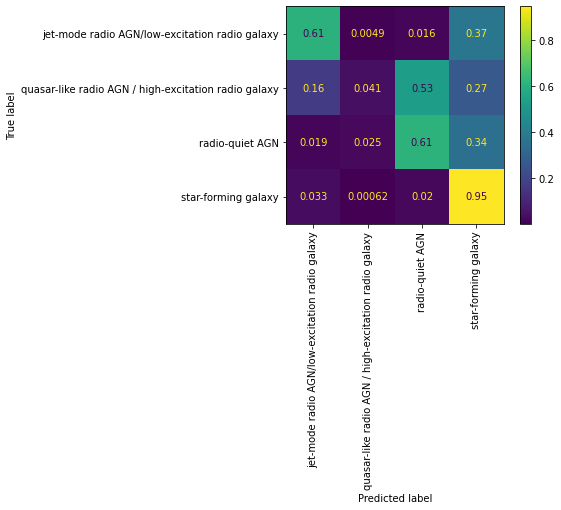

In [101]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# SVM

In [43]:
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [44]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8362    0.5038    0.6288       780
quasar-like radio AGN / high-excitation radio galaxy     1.0000    0.0092    0.0182       109
                                     radio-quiet AGN     0.7568    0.3676    0.4948       457
                                 star-forming galaxy     0.8118    0.9753    0.8861      3242

                                            accuracy                         0.8117      4588
                                           macro avg     0.8512    0.4640    0.5070      4588
                                        weighted avg     0.8149    0.8117    0.7828      4588



[]

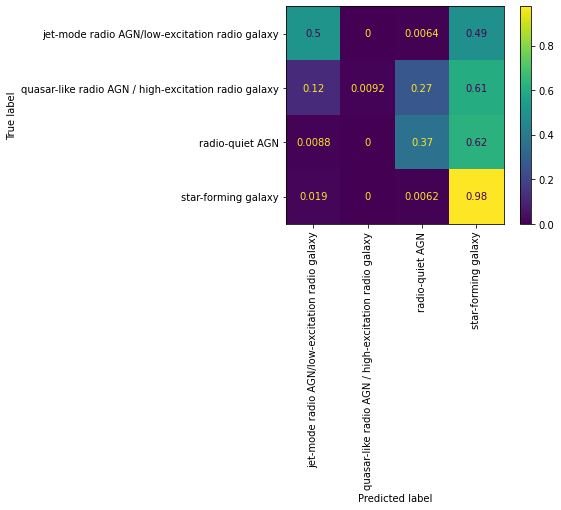

In [45]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()